# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose([transforms.RandomRotation(1),
                    transforms.ToTensor()
                  ])

# Create training and validation set
train_val_set = CIFAR10(root='../data', train=True, download=True, 
                            transform=transform)

#split the train and validation set
tlength, vlength = int(len(train_val_set)*0.9), len(train_val_set) - int(len(train_val_set)*0.9)
dataset_train, dataset_val = torch.utils.data.dataset.random_split(train_val_set, [tlength, vlength])


#create train and validation set dataloaders (putting them in batches)
train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset_val, batch_size=128, shuffle=True, drop_last=True)

# Create test set and define test dataloader
dataset_test = CIFAR10(root='../data', train=False, download=True, 
                            transform=transform)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=True, drop_last=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

frog


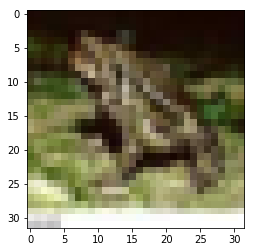

car


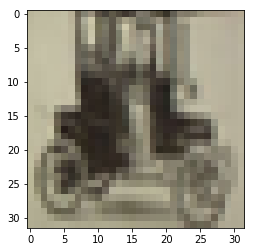

dog


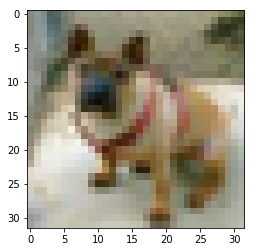

deer


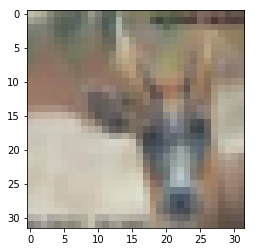

cat


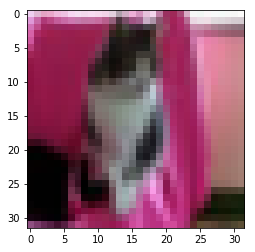

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()
        
show5(train_loader)

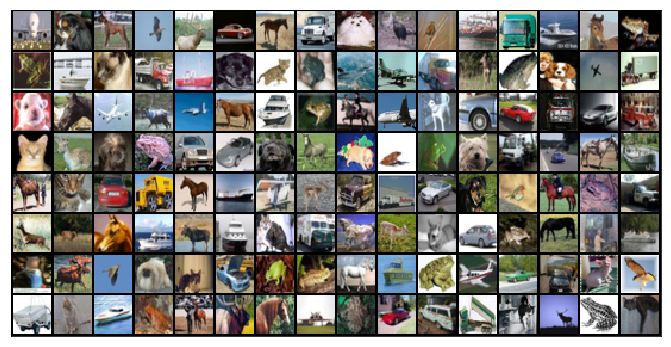

In [4]:
# Explore data
# Explore data
from torchvision.utils import make_grid

plt.figure(figsize=(100,100))
for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
plt.show()

In [5]:
img, label = dataset_train[7]
img.size()

torch.Size([3, 32, 32])

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        #loss function specified as cross-entropy loss
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def predict_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        acc = accuracy(out, labels)           # Calculate accuracy
        return acc
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [7]:
class CIFAR(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        
            # YOUR CODE HERE
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(5, 5)
        )        
        
        self.network2 = nn.Sequential(
            nn.Linear(256, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )    
    def forward(self, xb):
        batch_size = 128
        #print("{} -->".format(xb.size()), end=" ")
        
        x = self.network1(xb)
        #print("{} -->".format(x.size()), end=" ")
        
        x = x.view(batch_size, 256)
        #print("{} -->".format(x.size()), end=" ")
        
        final = self.network2(x)
        #print(final.size())
        
        return final

In [8]:
#see the model
model = CIFAR()
print(model)

CIFAR(
  (network1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (network2): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, 

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)
    #return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print("device:", device)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
model = model.to(device)

device: cuda


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
#@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 1.8439, val_loss: 1.5492, val_acc: 0.4199
Epoch [1], train_loss: 1.3852, val_loss: 1.2533, val_acc: 0.5453
Epoch [2], train_loss: 1.1135, val_loss: 1.0758, val_acc: 0.6258
Epoch [3], train_loss: 0.9272, val_loss: 0.9015, val_acc: 0.6905
Epoch [4], train_loss: 0.7959, val_loss: 0.8093, val_acc: 0.7175
Epoch [5], train_loss: 0.6960, val_loss: 0.7701, val_acc: 0.7270
Epoch [6], train_loss: 0.5990, val_loss: 0.6803, val_acc: 0.7638
Epoch [7], train_loss: 0.5208, val_loss: 0.6918, val_acc: 0.7628
Epoch [8], train_loss: 0.4480, val_loss: 0.6685, val_acc: 0.7780
Epoch [9], train_loss: 0.3757, val_loss: 0.6937, val_acc: 0.7776


Plot the training loss (and validation loss/accuracy, if recorded).

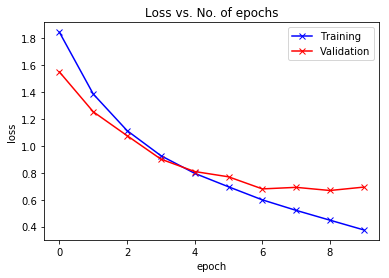

In [13]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
def test_model(model) :
    acc = []
    for batch in test_loader:
        batch_acc = model.predict_step(batch)
        acc.append(batch_acc)
    return np.array(acc).mean()
print( "Test Accuracy: {}".format( test_model(model) ) )

Test Accuracy: 0.7681289911270142


## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
torch.save(model.state_dict(), 'checkpoint.pth')

Loaded the model

In [16]:
checkpoint = torch.load('checkpoint.pth')

Initialized model with same structure.
Loaded in all the weightst to avoid train time.

In [17]:
fc_model = CIFAR()
fc_model.load_state_dict(checkpoint)
fc_model = fc_model.to(device)
fc_model

CIFAR(
  (network1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (network2): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, 

We should get same accuracy so testing out whether model loaded properly or not.

In [18]:
print( "Test Accuracy: {}".format( test_model(fc_model) ) )

Test Accuracy: 0.7682291865348816


## Make a Recommendation

**Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.**

Compared to the Detectocorp's model it does achieve that 70% accuracy. 

I changed up the model adding 6 CNN filters and every 2 filters I added Maxpooling layers.

There are a lot of things I can improve on. I can play with the learning rate, add more layers and make the model more complex, I can transform the pixels to make analysis better. I can also add dropout layers, train more epoch, and freeze certain layers performing.

My model is comparable to the Deep Belief Networks with better training and possible tweaking it might be able to get a slightly better accuracy, but it is not up to what the other models are. As a resul, I am not sure I would buy it.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).